In [77]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path
from sklearn.decomposition import FastICA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

## step1: Load and briefly inspect (WDBC Dataset)

In [78]:
# == Load IRIS ==

iris_cols = ["sepal_length","sepal_width","petal_length","petal_width","species"]

df_iris = pd.read_csv("../data/iris.data", header=None, names=iris_cols)
df_iris = df_iris.dropna(how="any")

X_iris = df_iris[["sepal_length","sepal_width","petal_length","petal_width"]].copy()
y_iris_true = df_iris["species"].copy()

# == Quick inspection ==
print("# shape:", X_iris.shape)
print("\n# head:")
print(X_iris.head())

print("\n# describe (first 5 cols):")
print(X_iris.describe())

print("\n# dtypes (first 5):")
print(X_iris.dtypes.head())

print("\n# missing values (total):", int(X_iris.isna().sum().sum()))

print("\n# species distribution:")
print(y_iris_true.value_counts())

print("\n# info:")
print(X_iris.info())

# == Standardize ==
scaler_iris = StandardScaler()
X_iris_standardized = pd.DataFrame(scaler_iris.fit_transform(X_iris), columns=X_iris.columns)

# keep
X_iris_raw = X_iris
y_iris_labels = y_iris_true


# shape: (150, 4)

# head:
   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2

# describe (first 5 cols):
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

# dtypes (first 5):
sepal_length    float64
sepal_width     float64


## step2: Collinearity & covariance (IRIS Dataset)

In [79]:
out_dir = Path("/home/sarafrz/python2023/feature_independence_project/outputs/figures")
out_dir.mkdir(parents=True, exist_ok=True)

# covariance shape: (4, 4)
# correlation shape: (4, 4)

# correlation matrix:
              sepal_length  sepal_width  petal_length  petal_width
sepal_length      1.000000    -0.109369      0.871754     0.817954
sepal_width      -0.109369     1.000000     -0.420516    -0.356544
petal_length      0.871754    -0.420516      1.000000     0.962757
petal_width       0.817954    -0.356544      0.962757     1.000000


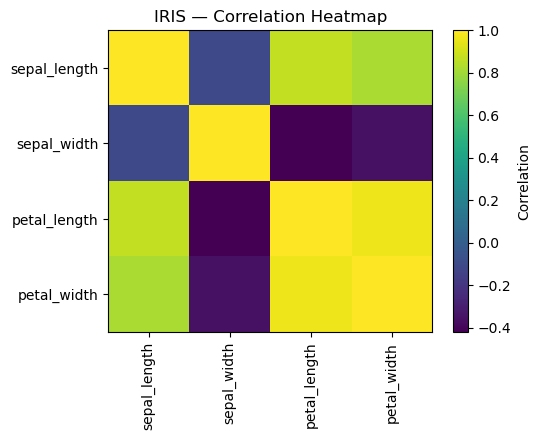

<Figure size 640x480 with 0 Axes>

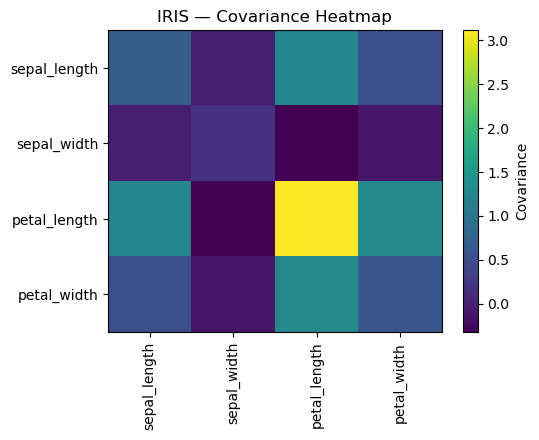

<Figure size 640x480 with 0 Axes>

In [80]:
## step2: Covariance and Correlation (IRIS)

# use X_iris_raw from step1
cov_iris = X_iris_raw.cov()
corr_iris = X_iris_raw.corr()

print("# covariance shape:", cov_iris.shape)
print("# correlation shape:", corr_iris.shape)
print("\n# correlation matrix:")
print(corr_iris)

# correlation heatmap
plt.figure(figsize=(5.5, 4.5))
plt.imshow(corr_iris.values, aspect="auto", interpolation="nearest")
plt.title("IRIS — Correlation Heatmap")
plt.colorbar(label="Correlation")
plt.xticks(np.arange(corr_iris.shape[1]), corr_iris.columns, rotation=90)
plt.yticks(np.arange(corr_iris.shape[0]), corr_iris.index)
plt.tight_layout()
plt.show()
plt.savefig(out_dir / "iris_corr_heatmap.png", dpi=150)


# covariance heatmap
plt.figure(figsize=(5.5, 4.5))
plt.imshow(cov_iris.values, aspect="auto", interpolation="nearest")
plt.title("IRIS — Covariance Heatmap")
plt.colorbar(label="Covariance")
plt.xticks(np.arange(cov_iris.shape[1]), cov_iris.columns, rotation=90)
plt.yticks(np.arange(cov_iris.shape[0]), cov_iris.index)
plt.tight_layout()
plt.show()
plt.savefig(out_dir / "iris_cov_heatmap.png", dpi=150)



In [81]:
# compute correlation (full feature set)
corr_iris = X_iris_raw.corr()

# upper triangle only
upper_mask = np.triu(np.ones(corr_iris.shape, dtype=bool), k=1)
corr_pairs_iris = (
    corr_iris.where(upper_mask)
             .stack()
             .reset_index()
             .rename(columns={"level_0": "feature_i", "level_1": "feature_j", 0: "corr"})
)

# filter by absolute threshold
threshold = 0.7
high_corr_iris = corr_pairs_iris[ corr_pairs_iris["corr"].abs() >= threshold ] \
                    .sort_values(by="corr", key=lambda s: s.abs(), ascending=False) \
                    .reset_index(drop=True)

print(f"# total feature pairs (IRIS): {corr_pairs_iris.shape[0]}")
print(f"# pairs with |r| >= {threshold}: {high_corr_iris.shape[0]}")
print("\n# all pairs with |r| >= threshold:")
print(high_corr_iris)

# keep for later use
high_corr_pairs_iris = high_corr_iris.copy()

# total feature pairs (IRIS): 6
# pairs with |r| >= 0.7: 3

# all pairs with |r| >= threshold:
      feature_i     feature_j      corr
0  petal_length   petal_width  0.962757
1  sepal_length  petal_length  0.871754
2  sepal_length   petal_width  0.817954


## step3: Feature extraction (IRIS — PCA, ICA, SVD)

In [82]:
## step3.1: matrix preview (IRIS)

X_std_iris = X_iris_standardized.values

pca_full_iris = PCA(n_components=None, svd_solver="full", random_state=42)
pca_full_iris.fit(X_std_iris)

print("# PCA matrices (IRIS)")
print("components_.shape:", pca_full_iris.components_.shape)
print("singular_values_.shape:", pca_full_iris.singular_values_.shape)
print("explained_variance_ratio_.shape:", pca_full_iris.explained_variance_ratio_.shape)

U_i, S_i, VT_i = np.linalg.svd(X_std_iris, full_matrices=False)
print("\n# SVD shapes (IRIS)")
print("U.shape:", U_i.shape)
print("S.shape:", S_i.shape)
print("VT.shape:", VT_i.shape)


# PCA matrices (IRIS)
components_.shape: (4, 4)
singular_values_.shape: (4,)
explained_variance_ratio_.shape: (4,)

# SVD shapes (IRIS)
U.shape: (150, 4)
S.shape: (4,)
VT.shape: (4, 4)


Explained variance ratio (all): [0.7277 0.2303 0.0368 0.0052]
Cumulative explained variance (all): [0.7277 0.958  0.9948 1.    ]
Chosen number of components (k) for target 95%: 2


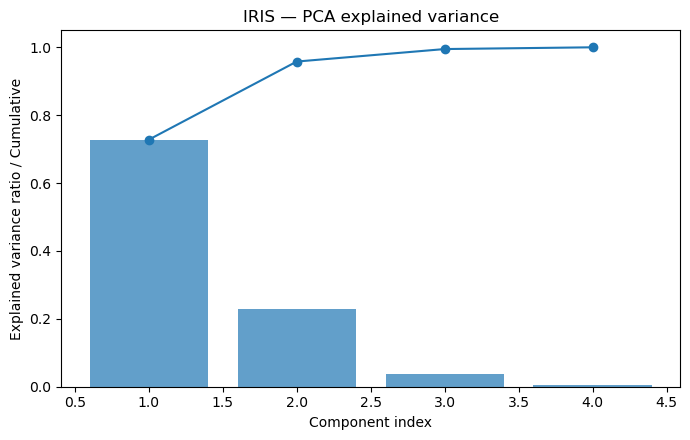

In [83]:
## step3.2: PCA choose k by EVR (IRIS)

# correct standardized data for IRIS
X_std_iris = X_iris_standardized.values

evr_target = 0.95  # adjustable if needed

pca_full_iris = PCA(n_components=None, svd_solver="full", random_state=42)
pca_full_iris.fit(X_std_iris)

evr_i = pca_full_iris.explained_variance_ratio_
evr_cum_i = np.cumsum(evr_i)
k_i = int(np.searchsorted(evr_cum_i, evr_target) + 1)

print("Explained variance ratio (all):", np.round(evr_i, 4))
print("Cumulative explained variance (all):", np.round(evr_cum_i, 4))
print(f"Chosen number of components (k) for target {evr_target*100:.0f}%:", k_i)

# plot + save

plt.figure(figsize=(7, 4.5))
plt.bar(range(1, len(evr_i)+1), evr_i, alpha=0.7)
plt.plot(range(1, len(evr_i)+1), evr_cum_i, marker="o")
plt.xlabel("Component index")
plt.ylabel("Explained variance ratio / Cumulative")
plt.title("IRIS — PCA explained variance")
plt.tight_layout()
plt.savefig(out_dir / "iris_pca_explained_variance.png", dpi=150)
plt.show()

k_iris = k_i


In [84]:
## step3.3: build new features (IRIS)

# PCA projection
pca_iris = PCA(n_components=k_iris, svd_solver="full", random_state=42)
X_iris_pca = pca_iris.fit_transform(X_std_iris)
X_iris_pca_df = pd.DataFrame(X_iris_pca, columns=[f"pc{i+1}" for i in range(k_iris)])

# ICA with same k
ica_iris = FastICA(n_components=k_iris, whiten="unit-variance", random_state=42, max_iter=1000)
X_iris_ica = ica_iris.fit_transform(X_std_iris)
X_iris_ica_df = pd.DataFrame(X_iris_ica, columns=[f"ic{i+1}" for i in range(k_iris)])

# SVD projection
U_i, S_i, VT_i = np.linalg.svd(X_std_iris, full_matrices=False)
V_k_i = VT_i[:k_iris, :].T
X_iris_svd = X_std_iris @ V_k_i
X_iris_svd_df = pd.DataFrame(X_iris_svd, columns=[f"svd{i+1}" for i in range(k_iris)])

print("# shapes (IRIS):")
print("X_iris_pca_df:", X_iris_pca_df.shape, "X_iris_ica_df:", X_iris_ica_df.shape, "X_iris_svd_df:", X_iris_svd_df.shape)

# keep models
pca_iris_model = pca_iris
ica_iris_model = ica_iris


# shapes (IRIS):
X_iris_pca_df: (150, 2) X_iris_ica_df: (150, 2) X_iris_svd_df: (150, 2)


## Step 4:Feature Selection (SelectKBest + RFE)

In [85]:
# step4.1: SelectKBest

X_i = X_iris_raw          
y_i = y_iris_labels          

k_i = 2                      # iris has 4 features; pick top-2

selector_i = SelectKBest(score_func=f_classif, k=k_i)
X_i_kbest = selector_i.fit_transform(X_i, y_i)

selected_features_i = X_i.columns[selector_i.get_support()]
print("# Selected features (IRIS - KBest):", list(selected_features_i))
print("Shape:", X_i_kbest.shape)


# Selected features (IRIS - KBest): ['petal_length', 'petal_width']
Shape: (150, 2)


In [86]:
# step4.2: RFE 

logreg_i = LogisticRegression(max_iter=5000, solver="liblinear")
rfe_i = RFE(estimator=logreg_i, n_features_to_select=k_i)

X_i_rfe = rfe_i.fit_transform(X_i, y_i)
selected_rfe_i = X_i.columns[rfe_i.get_support()]
print("# Selected features (IRIS - RFE):", list(selected_rfe_i))
print("Shape:", X_i_rfe.shape)


# Selected features (IRIS - RFE): ['sepal_width', 'petal_width']
Shape: (150, 2)


## step5: KMeans — original vs PCA vs RFE

In [87]:
## step5C.run: KMeans on original vs PCA vs RFE (report inertia, silhouette, n_iter, times)

import time
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -- choose number of clusters (IRIS has 3 species; set to 2 if desired)
K = 3  # change to 2 for the k=2 scenario

def run_kmeans(X, name):
    # fit timing
    t0 = time.perf_counter()
    km = KMeans(n_clusters=K, n_init=10, random_state=42)
    km.fit(X)
    fit_t = time.perf_counter() - t0

    # predict timing
    t1 = time.perf_counter()
    labels = km.predict(X)
    pred_t = time.perf_counter() - t1

    # metrics
    inertia = km.inertia_
    sil = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else float('nan')
    iters = km.n_iter_

    print(f"[KMeans] {name:>8} | inertia: {inertia:.4f} | silhouette: {sil:.4f} | n_iter: {iters} | fit_time(s): {fit_t:.6f} | pred_time(s): {pred_t:.6f}")

# -- runs on three feature spaces
run_kmeans(X_iris_std,    "original")
run_kmeans(X_iris_pca_arr,"PCA")
run_kmeans(X_iris_rfe_arr,"RFE")


[KMeans] original | inertia: 140.9658 | silhouette: 0.4590 | n_iter: 4 | fit_time(s): 0.014908 | pred_time(s): 0.000259
[KMeans]      PCA | inertia: 116.1092 | silhouette: 0.5082 | n_iter: 4 | fit_time(s): 0.011314 | pred_time(s): 0.000205
[KMeans]      RFE | inertia: 80.3372 | silhouette: 0.4604 | n_iter: 4 | fit_time(s): 0.007811 | pred_time(s): 0.000182


## Step 6: summarize & compare

In [88]:
## step6C: summarize clustering results (IRIS)

# original standardized
if   'X_iris_std' in globals(): Xo = np.asarray(X_iris_std)
elif 'X_std_iris' in globals(): Xo = np.asarray(X_std_iris)
elif 'X_iris_standardized' in globals(): Xo = np.asarray(X_iris_standardized.values)
else: raise NameError("Missing standardized original: X_iris_std or X_std_iris or X_iris_standardized.")

# PCA space
if   'X_iris_pca_arr' in globals(): Xp = np.asarray(X_iris_pca_arr)
elif 'X_iris_pca'     in globals(): Xp = np.asarray(X_iris_pca)
elif 'X_iris_pca_df'  in globals(): Xp = np.asarray(X_iris_pca_df.values)
else: raise NameError("Missing PCA space: X_iris_pca_arr / X_iris_pca / X_iris_pca_df.")

# RFE space
if   'X_iris_rfe_arr' in globals(): Xr = np.asarray(X_iris_rfe_arr)
elif 'X_i_rfe'        in globals():
    sc_rfe6 = StandardScaler()
    Xr = sc_rfe6.fit_transform(np.asarray(X_i_rfe))
else: raise NameError("Missing RFE space: X_iris_rfe_arr or X_i_rfe.")

# -- KMeans runner
def run_kmeans(X, name, K=3):
    t0 = time.perf_counter()
    km = KMeans(n_clusters=K, n_init=10, random_state=42)
    km.fit(X)
    fit_t = time.perf_counter() - t0

    t1 = time.perf_counter()
    labels = km.predict(X)
    pred_t = time.perf_counter() - t1

    inertia = km.inertia_
    sil = silhouette_score(X, labels) if len(np.unique(labels))>1 else float('nan')
    iters = km.n_iter_

    return {"space":name, "inertia":inertia, "silhouette":sil, "n_iter":iters,
            "fit_time":fit_t, "pred_time":pred_t}

# -- run all three spaces (k=3 by default)
res = []
res.append(run_kmeans(Xo, "original", K=3))
res.append(run_kmeans(Xp, "PCA",      K=3))
res.append(run_kmeans(Xr, "RFE",      K=3))

df_clu = pd.DataFrame(res)

# -- deltas vs original
base = df_clu[df_clu["space"]=="original"].iloc[0]
df_clu["Δinertia_vs_orig"]   = df_clu["inertia"]   - base["inertia"]
df_clu["Δsilhouette_vs_orig"]= df_clu["silhouette"]- base["silhouette"]
df_clu["speedup_fit_vs_orig"]= base["fit_time"] / df_clu["fit_time"]
df_clu["speedup_pred_vs_orig"]= base["pred_time"] / df_clu["pred_time"]

print("# clustering summary (IRIS)")
print(df_clu.to_string(index=False))


# clustering summary (IRIS)
   space    inertia  silhouette  n_iter  fit_time  pred_time  Δinertia_vs_orig  Δsilhouette_vs_orig  speedup_fit_vs_orig  speedup_pred_vs_orig
original 140.965817    0.458972       4  0.019287   0.000397          0.000000             0.000000             1.000000              1.000000
     PCA 116.109240    0.508155       4  0.011960   0.000242        -24.856576             0.049183             1.612572              1.638872
     RFE  80.337157    0.460425       4  0.010626   0.000239        -60.628659             0.001453             1.815093              1.662892


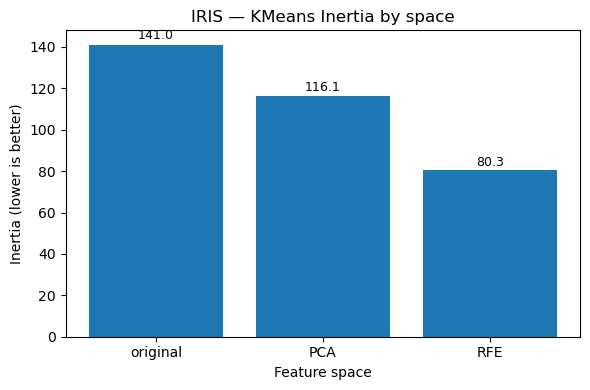

Saved: ../outputs/figures/iris_kmeans_inertia_by_space.png


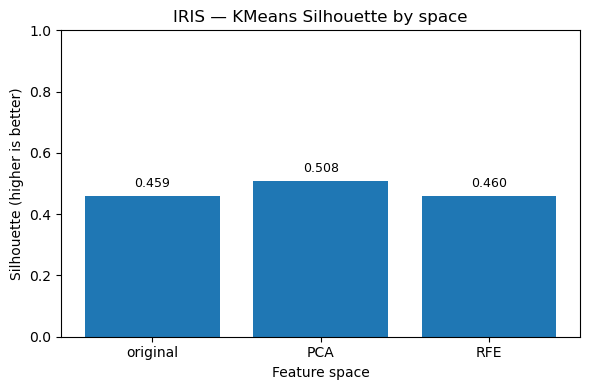

Saved: ../outputs/figures/iris_kmeans_silhouette_by_space.png


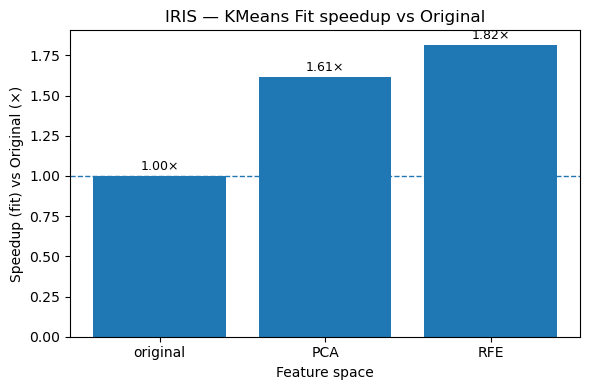

Saved: ../outputs/figures/iris_kmeans_speedup_fit_vs_original.png


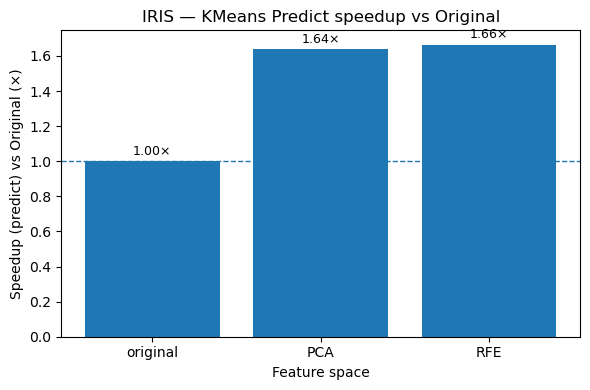

Saved: ../outputs/figures/iris_kmeans_speedup_predict_vs_original.png


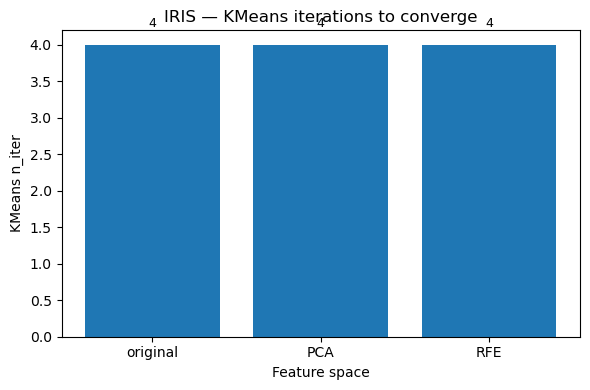

Saved: ../outputs/figures/iris_kmeans_n_iter_by_space.png


In [89]:
# ensure output dir
out_dir = Path("../outputs/figures")
out_dir.mkdir(parents=True, exist_ok=True)

# enforce order
space_order = ["original", "PCA", "RFE"]
dfc = df_clu.copy()
dfc["space"] = pd.Categorical(dfc["space"], categories=space_order, ordered=True)
dfc = dfc.sort_values("space")

# save table (optional)
dfc.to_csv(out_dir.parent / "iris_clu_summary.csv", index=False)

# --- 1) Inertia (lower is better)
plt.figure(figsize=(6,4))
plt.bar(dfc["space"].astype(str), dfc["inertia"].values)
plt.ylabel("Inertia (lower is better)")
plt.xlabel("Feature space")
plt.title("IRIS — KMeans Inertia by space")
for x, v in zip(dfc["space"].astype(str), dfc["inertia"].values):
    plt.text(x, v * 1.01 if v>0 else 0.01, f"{v:.1f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
fname = out_dir / "iris_kmeans_inertia_by_space.png"
plt.savefig(fname, dpi=150); plt.show()
print(f"Saved: {fname}")

# --- 2) Silhouette (higher is better)
plt.figure(figsize=(6,4))
plt.bar(dfc["space"].astype(str), dfc["silhouette"].values)
plt.ylabel("Silhouette (higher is better)")
plt.xlabel("Feature space")
plt.ylim(0, 1.0)
plt.title("IRIS — KMeans Silhouette by space")
for x, v in zip(dfc["space"].astype(str), dfc["silhouette"].values):
    plt.text(x, min(0.97, v + 0.02), f"{v:.3f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
fname = out_dir / "iris_kmeans_silhouette_by_space.png"
plt.savefig(fname, dpi=150); plt.show()
print(f"Saved: {fname}")

# --- 3) Speedup fit vs Original (×) — baseline at 1
plt.figure(figsize=(6,4))
plt.axhline(1.0, linestyle="--", linewidth=1)
plt.bar(dfc["space"].astype(str), dfc["speedup_fit_vs_orig"].values)
plt.ylabel("Speedup (fit) vs Original (×)")
plt.xlabel("Feature space")
plt.title("IRIS — KMeans Fit speedup vs Original")
for x, v in zip(dfc["space"].astype(str), dfc["speedup_fit_vs_orig"].values):
    if np.isfinite(v):
        plt.text(x, v + 0.02, f"{v:.2f}×", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
fname = out_dir / "iris_kmeans_speedup_fit_vs_original.png"
plt.savefig(fname, dpi=150); plt.show()
print(f"Saved: {fname}")

# --- 4) Speedup predict vs Original (×) — baseline at 1
plt.figure(figsize=(6,4))
plt.axhline(1.0, linestyle="--", linewidth=1)
plt.bar(dfc["space"].astype(str), dfc["speedup_pred_vs_orig"].values)
plt.ylabel("Speedup (predict) vs Original (×)")
plt.xlabel("Feature space")
plt.title("IRIS — KMeans Predict speedup vs Original")
for x, v in zip(dfc["space"].astype(str), dfc["speedup_pred_vs_orig"].values):
    if np.isfinite(v):
        plt.text(x, v + 0.02, f"{v:.2f}×", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
fname = out_dir / "iris_kmeans_speedup_predict_vs_original.png"
plt.savefig(fname, dpi=150); plt.show()
print(f"Saved: {fname}")

# --- 5) Number of iterations to converge
plt.figure(figsize=(6,4))
plt.bar(dfc["space"].astype(str), dfc["n_iter"].values)
plt.ylabel("KMeans n_iter")
plt.xlabel("Feature space")
plt.title("IRIS — KMeans iterations to converge")
for x, v in zip(dfc["space"].astype(str), dfc["n_iter"].values):
    plt.text(x, v + 0.2, f"{int(v)}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
fname = out_dir / "iris_kmeans_n_iter_by_space.png"
plt.savefig(fname, dpi=150); plt.show()
print(f"Saved: {fname}")